Reading rx power tensor so we can calculate SNR. 

In [1]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor[rx_power_tensor==0] = -np.infty
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts


#print(np.sum((rx_power_tensor==0.0)))
#print(10**(-0.1*np.infty))

print(np.min(rx_power_tensor))

0.0


Calculating SNR. Non-existent paths have been assigned -250 dB SNR which is very low.

In [2]:
BW = 400e6 #bandwidth
k = 1.38e-23 #boltzmann's constant
NF = 10**(0.9) #noise figue 
T = 298 #temperature

NoisePower = k*BW*NF*T


SNRs = rx_power_tensor/NoisePower

SNRs[SNRs==0.0] = 1e-25 # no paths to -250 dB SNR
print(np.sum((SNRs==1e-25))) # total number of non exisitent paths


54582


Reading all other characteristics and adding noise


In [3]:


import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aoa_tensor = azimuth_aoa_tensor + azimuth_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))



mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aod_tensor = azimuth_aod_tensor + azimuth_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aod_tensor = zenith_aod_tensor + zenith_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aoa_tensor = zenith_aoa_tensor + zenith_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

# mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
# rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
# rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
# rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms
toa_tensor = toa_tensor + toa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


In [4]:
print(azimuth_aoa_tensor.shape)

(150000, 4, 25)


**Constructing the input tensor with dimensions n_samples x n_bs x n_paths x n_features**

In [5]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


Each input sample has a shape 600x1

In [6]:


from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

**Simple deep dense neural network (DDNN) approach**
Constructing DDNN and declaring all hyper-parameters. We tried batchnorm and dropout. It resulted in worse performance

In [7]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0) ### assuming we know the minimum coordinates, done for stability of relu
true_cord_tensor = true_cord_tensor*1



model = models.Sequential()
model.add(layers.Dense(256, input_shape=(n_features*n_paths*n_bs,),activation = 'relu'))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam()

model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               153856    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
_________________________________________________________________
None


Training split. Preprocessing data.


In [8]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_tensor, true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler() # preprocessing data
scaled_df = scaler.fit(X_train)
scaled_df = scaler.transform(X_train)

Running training. 

In [9]:
Running training. model.fit(scaled_df, y_train, epochs=500, batch_size=32, verbose = 2)

Epoch 1/500
2344/2344 - 3s - loss: 4838.9019
Epoch 2/500
2344/2344 - 3s - loss: 1371.7029
Epoch 3/500
2344/2344 - 3s - loss: 946.0866
Epoch 4/500
2344/2344 - 3s - loss: 760.1234
Epoch 5/500
2344/2344 - 3s - loss: 671.4398
Epoch 6/500
2344/2344 - 3s - loss: 573.0653
Epoch 7/500
2344/2344 - 3s - loss: 485.7831
Epoch 8/500
2344/2344 - 3s - loss: 574.9863
Epoch 9/500
2344/2344 - 4s - loss: 446.4397
Epoch 10/500
2344/2344 - 3s - loss: 444.9128
Epoch 11/500
2344/2344 - 3s - loss: 320.3342
Epoch 12/500
2344/2344 - 3s - loss: 380.9415
Epoch 13/500
2344/2344 - 3s - loss: 273.4227
Epoch 14/500
2344/2344 - 3s - loss: 519.8828
Epoch 15/500
2344/2344 - 3s - loss: 355.0434
Epoch 16/500
2344/2344 - 3s - loss: 230.0077
Epoch 17/500
2344/2344 - 3s - loss: 367.4956
Epoch 18/500
2344/2344 - 3s - loss: 329.4266
Epoch 19/500
2344/2344 - 3s - loss: 223.4452
Epoch 20/500
2344/2344 - 3s - loss: 230.6025
Epoch 21/500
2344/2344 - 3s - loss: 186.9421
Epoch 22/500
2344/2344 - 3s - loss: 185.7529
Epoch 23/500
2344

2344/2344 - 3s - loss: 33.2287
Epoch 185/500
2344/2344 - 3s - loss: 180.8214
Epoch 186/500
2344/2344 - 3s - loss: 34.9790
Epoch 187/500
2344/2344 - 3s - loss: 34.0474
Epoch 188/500
2344/2344 - 3s - loss: 33.5233
Epoch 189/500
2344/2344 - 3s - loss: 33.8466
Epoch 190/500
2344/2344 - 3s - loss: 33.6070
Epoch 191/500
2344/2344 - 3s - loss: 197.1151
Epoch 192/500
2344/2344 - 3s - loss: 33.1182
Epoch 193/500
2344/2344 - 3s - loss: 33.5378
Epoch 194/500
2344/2344 - 3s - loss: 80.4585
Epoch 195/500
2344/2344 - 3s - loss: 32.6614
Epoch 196/500
2344/2344 - 3s - loss: 69.2743
Epoch 197/500
2344/2344 - 3s - loss: 42.1078
Epoch 198/500
2344/2344 - 3s - loss: 33.4877
Epoch 199/500
2344/2344 - 4s - loss: 32.6392
Epoch 200/500
2344/2344 - 4s - loss: 32.5538
Epoch 201/500
2344/2344 - 4s - loss: 82.5534
Epoch 202/500
2344/2344 - 3s - loss: 33.3323
Epoch 203/500
2344/2344 - 4s - loss: 43.6680
Epoch 204/500
2344/2344 - 4s - loss: 31.8110
Epoch 205/500
2344/2344 - 3s - loss: 32.6491
Epoch 206/500
2344/234

2344/2344 - 3s - loss: 25.4493
Epoch 367/500
2344/2344 - 3s - loss: 24.9179
Epoch 368/500
2344/2344 - 3s - loss: 25.4306
Epoch 369/500
2344/2344 - 4s - loss: 25.4324
Epoch 370/500
2344/2344 - 4s - loss: 25.5464
Epoch 371/500
2344/2344 - 5s - loss: 25.8929
Epoch 372/500
2344/2344 - 4s - loss: 25.1542
Epoch 373/500
2344/2344 - 4s - loss: 25.4606
Epoch 374/500
2344/2344 - 5s - loss: 25.7493
Epoch 375/500
2344/2344 - 5s - loss: 26.9992
Epoch 376/500
2344/2344 - 5s - loss: 25.3456
Epoch 377/500
2344/2344 - 4s - loss: 37.4158
Epoch 378/500
2344/2344 - 4s - loss: 25.3169
Epoch 379/500
2344/2344 - 3s - loss: 25.7980
Epoch 380/500
2344/2344 - 3s - loss: 70.5488
Epoch 381/500
2344/2344 - 4s - loss: 29.4875
Epoch 382/500
2344/2344 - 4s - loss: 25.4106
Epoch 383/500
2344/2344 - 4s - loss: 28.4137
Epoch 384/500
2344/2344 - 4s - loss: 25.0819
Epoch 385/500
2344/2344 - 6s - loss: 44.1770
Epoch 386/500
2344/2344 - 4s - loss: 24.6268
Epoch 387/500
2344/2344 - 4s - loss: 267.0809
Epoch 388/500
2344/2344

Predicting on all data. 

In [10]:
pred_vals = model.predict(scaler.transform(input_tensor)) +  np.min(true_cord_tensor)*0

pred_train = modelPredicting on all data. .predict(scaled_df)
pred_test = model.predict(scaler.transform(X_test))

In case we need to calculate errors in training, testing, overall. 

In [11]:
#pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

Calculating error norms. 

In [12]:
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
print(norm_error.shape)

(150000,)


Constructing CDFs. 

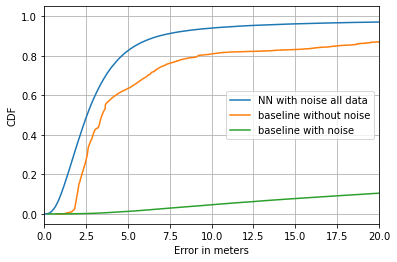

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

# cdf = ECDF(norm_error_train/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


# cdf = ECDF(norm_error_test/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


mat = scipy.io.loadmat('baselineerror.mat')
err_data = mat['err_data']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)


mat = scipy.io.loadmat('erorwithnoise.mat')
err_data = mat['eroraray']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)

plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['NN with noise all data','baseline without noise','baseline with noise'])


Mean error

In [14]:
print(np.mean(norm_error))Mean error

7.55435213393879


80% CDF intersection point  

In [15]:
cdf = ECDF(norm_error/1)
y = cdf.y
indx = cdf.x[y>0.8]
#print(" {0}":)
print("The 80% percentile error in meters is ", indx[0], end='')

The 80% percentile error in meters is  4.6376486065144915

In [16]:
#model.save('uav_localize_normalized_inputs_noise_samearch_model')

Saving error array

In [17]:
scipy.io.savemat('DDNN_with_noise_samearch_error.mat', {'norm_error':norm_error})